In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
from sklearn.metrics import accuracy_score
import random

Using TensorFlow backend.


# Loading and Creation of the Datasets

In [2]:
(X_train, Y_train), (X_test, Y_test)=mnist.load_data()

In [3]:
X_total=np.concatenate((X_train,X_test))
Y_total=np.concatenate((Y_train,Y_test))
X_Train=X_total[0:42000,:,:]
Y_Train=Y_total[0:42000]
X_Val=X_total[42000:56000,:,:]
Y_Val=Y_total[42000:56000]
X_Test=X_total[56000:,:,:]
Y_Test=Y_total[56000:]

0


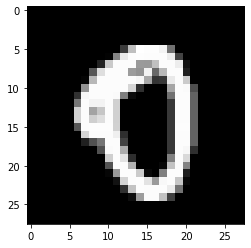

In [4]:
plt.imshow(X_Val[11936],cmap='gray')
print(Y_Val[11936])

In [5]:
### Flattening the images
num_pixels=X_train.shape[1]*X_train.shape[2]
print(num_pixels)
X_Train=X_Train.reshape(X_Train.shape[0],num_pixels)
X_Val=X_Val.reshape(X_Val.shape[0],num_pixels)
X_Test=X_Test.reshape(X_Test.shape[0],num_pixels)

784


In [6]:
### Binarization of the vectors using thresholding
for i in range(X_Train.shape[0]):
    X_Train[i]=np.array(X_Train[i]>127,dtype='int32')
    if i<X_Test.shape[0]:
        X_Test[i]=np.array(X_Test[i]>127,dtype='int32')
        X_Val[i]=np.array(X_Val[i]>127,dtype='int32')

0


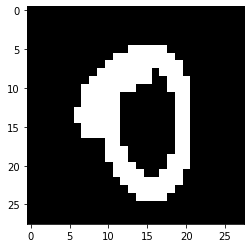

In [7]:
plt.imshow(X_Val[11936].reshape(28,28),cmap='gray')
print(Y_Val[11936])

# Creating 50 Decision trees

In [8]:
def create_decision_tree(X_Train,Y_Train,X_Val,Y_Val):
    ## Choosing 10 random features
    feature_space=random.sample(range(X_Train.shape[1]),10)
      
    temp_train=X_Train[:,feature_space]
    temp_val=X_Val[:,feature_space]
        
    dtree=tree.DecisionTreeClassifier(max_depth=5)
    dtree=dtree.fit(temp_train,Y_Train)
    pred_val=dtree.predict(temp_val)
    acc=accuracy_score(Y_Val,pred_val)
    return feature_space,acc,dtree

In [9]:
tree_weight={}  ## Accuracy on validation set
tree_features={} ## Features used by the particular tree
tree_model={}    ## ith tree model
for i in range(50):
    tree_features[i],tree_weight[i],tree_model[i] =create_decision_tree(X_Train,Y_Train,X_Val,Y_Val)

# weighted classification of the test set using these 50 decision trees

In [10]:
def random_forest(X,Y):
    correct=0
    error=np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        prob=np.zeros((1,10))
        for item in tree_model.keys():
            ## First selecting the features of the testing item which the particular decision tree uses
            temp=X[i][tree_features[item]].reshape(1,-1)
            ## Weighted probabilities of each classes(0-9)
            prob+=(tree_weight[item]*tree_model[item].predict_proba(temp))
    
        if np.argmax(prob)==Y[i]:  ## Correct prediction
            correct+=1
        else:
            error[i]=1
    accuracy=correct/X.shape[0]
    return accuracy,error

In [11]:
## Cell takes some time to run ##
test_accuracy,_ = random_forest(X_Test,Y_Test)
print("Accuracy on the test using weighted classification with 50 Decision trees = ", test_accuracy)

Accuracy on the test using weighted classification with 50 Decision trees =  0.7864285714285715


# Ensemble Classification using Adaboost

In [24]:
def update(Weight, error):
    e=np.sum(error)
    K=10
    performance=0.5*(np.log((1-e)/e) + np.log(K-1))  ## Where K is total number of classes (for K=2, formula becomes same as binary classification)
    for i in range(W.shape[0]):
        if error[i]!=0:
            Weight[i]*=np.exp(performance)
        else:
            Weight[i]*=np.exp(-performance)
    Weight=Weight/np.sum(Weight)
    return performance, Weight

In [14]:
## Cell takes some time to run ##
## Initialize the weights of all samples
N=X_Train.shape[0]
W=np.ones(N)/N

## Taking the base classifier as the Random forest
acc,err=random_forest(X_Train,Y_Train)
base_error=np.multiply(W,err)
base_perf, W = update(W, base_error)
## Now this updated W would act as base weight vector for the following iterations

In [31]:
base_perf

1.6867068460992916

In [32]:
## Cell takes some time to run ##
Wn=W
perf={}
model={}
for it in range(20):
    dt=tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
    dt=dt.fit(X_Train,Y_Train,sample_weight=Wn)
    error=np.array(dt.predict(X_Train)!=Y_Train, dtype='int32')
    temp=np.multiply(Wn, error) ## Weighted error vector
    perf[it], Wn = update(Wn, temp)
    model[it]=dt

In [33]:
perf

{0: 1.1358191232676285,
 1: 0.9202785140711103,
 2: 0.8212707836327383,
 3: 0.854610700969433,
 4: 0.7814528705925419,
 5: 0.7304156177286876,
 6: 0.7482750825791875,
 7: 0.7719720921928754,
 8: 0.7799861432275803,
 9: 0.7643980482185475,
 10: 0.6794714366388732,
 11: 0.7396544133119162,
 12: 0.7675815008180458,
 13: 0.7257152393505926,
 14: 0.7396862350008646,
 15: 0.7422861123017742,
 16: 0.7644173239210792,
 17: 0.7962430118803527,
 18: 0.7274574294669702,
 19: 0.7736783705260835}

# Prediction on Test set

In [34]:
## Function giving prediction for the base classifier
def base_pred(X):
    
    prob=np.zeros((1,10))
    for item in tree_model.keys():        
        ## First selecting the features of the testing item which the particular decision tree uses
        temp=X[tree_features[item]].reshape(1,-1)
        ## Weighted probabilities of each classes(0-9)
        prob+=(tree_weight[item]*tree_model[item].predict_proba(temp))
    
    return np.argmax(prob)

In [40]:
## Cell takes some time to run ##
Y_pred=np.empty(X_Test.shape[0])
for i in range(X_Test.shape[0]):
    prob=np.zeros(10)
    prob[base_pred(X_Test[i])]+=base_perf
    for item in model.keys():
        prob[model[item].predict(X_Test[i].reshape(1,-1))]+=perf[item]
    Y_pred[i]=np.argmax(prob)

In [47]:
prediction_acc = accuracy_score(Y_Test, Y_pred)

In [51]:
print("Accuracy on test set by Adaboost algorithm =", prediction_acc)

Accuracy on test set by Adaboost algorithm = 0.8550714285714286


In [ ]:
       #### Hence Accuracy increases on implementation of Adaboost Algorithm #####